In [9]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDB"
)
mycursor = mydb.cursor()

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]


In [15]:
user_id = 245

for user_id in users:
    user_df = pd.read_sql('SELECT nomon_sessions, rowcol_sessions FROM study_info WHERE id ='+str(user_id), con=mydb)
    
    software_names = {"nomon": "Nomon", "rowcol": "RCS"}
    
    software = "nomon"
    
    sns.set_context("paper")
    sns.set_style("whitegrid")
    
    software_sessions = user_df[software+"_sessions"].values[0]
    with sns.color_palette("ch:2.5,-.2,dark=.3"):
        
        for session_num in range(1, software_sessions+1):
            data_table = software + "_session_"+str(session_num)+"_user_"+str(user_id)
            
            mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
            phrase_nums = np.array(mycursor.fetchall()).T[0]
            session_click_times = []
            session_time_rotates = []
            for phrase_num in phrase_nums:
                mycursor.execute("SELECT rel_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp ASC")
                click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
                while len(click_times[0]) == 0:
                    click_times = click_times[1:]
                flattened_click_times = [time for selection in click_times for time in selection]
                session_click_times += flattened_click_times
                
                mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                         " ORDER BY timestamp DESC LIMIT 1")
                rotate_ind = mycursor.fetchall()[0][0]
                session_time_rotates.append(time_rotate_li[rotate_ind])
            
            print(2*np.std(session_click_times), " ", session_time_rotates[-1], " ", session_num)
            # sns.kdeplot(session_click_times)
            # sns.rugplot(session_click_times)

48.03611140453487   4.0   1
40.614473608121585   4.0   2
31.201622213171216   4.0   3
40.38683647187915   3.619349672143838   4
0.22355227359047158   3.2749230123119273   5
0.22124379665033686   3.2749230123119273   6
0.19443177464822392   3.2749230123119273   7
0.20009135638635517   3.2749230123119273   8
0.21329480519625493   3.2749230123119273   9
0.21819310279816126   3.2749230123119273   10
0.4401354719384108   4.0   1
0.3961065257690629   4.0   2
0.46672040663357367   4.0   3
0.5607047871445549   4.0   4
0.43963678687851376   4.0   5
0.36174751845613645   4.0   6
0.5214073973006191   4.0   7
0.34776402156672254   4.0   8
0.38300905977264826   4.0   9
0.3276270126588109   4.0   10
0.4061663223727451   4.0   1
0.27178688749068547   3.2749230123119273   2
0.29937283783775454   3.619349672143838   3
0.22771719180710076   3.619349672143838   4
0.2652313599620351   2.9632728827268715   5
0.23283740907821676   2.9632728827268715   6
0.24638623324412848   2.9632728827268715   7
0.2076899

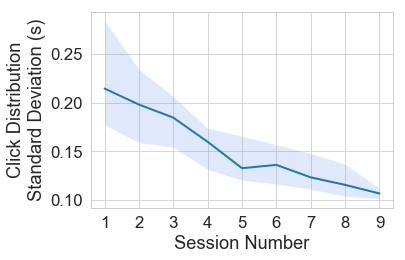

In [12]:
def calculate_quantiles(plot_df, metric):
    lower_quantiles = plot_df[["Session Number",metric]].groupby(by=["Session Number"]).quantile(q=0.25)
    lower_quantiles = lower_quantiles.reset_index()
    nomon_lower_quantiles = lower_quantiles[metric].values
    
    upper_quantiles = plot_df[["Session Number",metric]].groupby(by=["Session Number"]).quantile(q=0.75)
    upper_quantiles = upper_quantiles.reset_index()
    nomon_upper_quantiles = upper_quantiles[metric].values
    
    return {"lower": nomon_lower_quantiles,
            "upper": nomon_upper_quantiles}

software_names = {"nomon": "Nomon", "rowcol": "RCS"}
software = "nomon"

var_df = pd.DataFrame(columns=["id", "Session Number", "Standard Deviation (s)"])

for user_id in users:
    user_df = pd.read_sql('SELECT nomon_sessions, rowcol_sessions FROM study_info WHERE id ='+str(user_id), con=mydb)
    software_sessions = user_df[software+"_sessions"].values[0]

    if user_id == 98:
        session_start=5
    else:
        session_start=1
    for session_num in range(session_start, software_sessions):
    
        data_table = software + "_session_"+str(session_num)+"_user_"+str(user_id)
        
        mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
        phrase_nums = np.array(mycursor.fetchall()).T[0]
        
        session_click_times = []
        for phrase_num in phrase_nums:
            mycursor.execute("SELECT rel_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp ASC")
            click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
            while len(click_times[0]) == 0:
                click_times = click_times[1:]
            flattened_click_times = [time for selection in click_times for time in selection]
            session_click_times += flattened_click_times
            
        var_df = var_df.append({"id": user_id, "Session Number": session_num, "Standard Deviation (s)": np.std(session_click_times)}, ignore_index=True)
        

sns.set_context("paper", font_scale=1.9)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
plt.subplots_adjust(left=0.2, bottom=0.2)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Standard Deviation (s)", data=var_df, ax=ax, estimator=np.median, ci=None, linewidth=2)
ax.set_ylabel("Click Distribution\nStandard Deviation (s)")

scan_quantiles = calculate_quantiles(var_df, "Standard Deviation (s)")
ax.fill_between(range(1, 10), scan_quantiles["lower"], scan_quantiles["upper"],
                where=scan_quantiles["upper"] >= scan_quantiles["lower"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)


plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/click_dist.png", dpi=300)
plt.show()
